### Audi- etron GT charging time calculation

BMS strategy of CCCV

current limitations for cells are taken from online resources

##### LG Chem E66A
- Pouch Cell
- Nominal Capacity: 65 Ah
- Minimum Capacity: 63.5 Ah
- Current
    - Continuous : 121 A
    - peak       : 297 A
- Energy : C/10 232.2 W

(C/10 energy by discharging the cell at an ambient temperature of 25°C from 100% with a constant current of 6.50A (0.1C) until reaching the voltage of 2.5V. The thermal boundary condition is free convection.)
- Power 
    - Continuous : 0.41 kW
    - Peak       : 1.04 kW 

Peak power is for 5 minutes untill either voltage reaches minimum or cell surface temperature reaches $60^o$C
- Current range : 325 A discharge - 98 A charge(5C to 1C)    
- temperature range : $-20^o C$ to $60^o C$
- Nominal Voltage: 3.657 V
- Nominal energy: 237.7 Wh
- Minimum energy: 232.2 Wh
- Dimensions: 104 X 350 X 11.7 mm
- Volume: 0,425880 L
- Weight: 897 g
- Volumetric Energy Density: 648 Wh/L
- Gravimetric Energy Density: 259 Wh/kg
- Chemistry: NCM 712

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate

In [42]:
class cell:
    # values are currently used from literature, but in future
    # values will be extracted from dataset
    # OCV values - 25 degrees
    type = 'NMC' 
    C_nom = None
    v_nom = None
    I_cont = None
    I_peak = None
    soh = None
    soh_index =[1,0.5,0]
    soc_reduction = [1,0.95,0.8]
    soc = [0,2,4,6,8,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,\
                85,90,92,94,96,98,100]
    ocv = [3.3,3.4,3.48,3.5,3.52,3.54,3.56,3.57, 3.58, 3.59, 3.61, 3.63,\
          3.64, 3.67, 3.7,3.725,3.75, 3.8, 3.85, 3.9, 3.95,4,4.04,4.08,4.12,4.16,4.2]
    temp_range=[0,5,10,15,20,25,30,35,40,45,50]
    R_mean_cont = 0.0025
    R_mean_fast = 0.004
    
    def soc_estimate(cls,soh):
        f = interpolate.interp1d(cls.soh_index,cls.soc_reduction)
        soc = f(soh)*cls.soc
        return soc
    def R_estimate(cls,soh):
        R_mean_cont = cls.R_mean_cont/soh
        R_mean_fast = cls.R_mean_fast/soh
        return R_mean_cont,R_mean_fast

class ESS:
    def __init__(self, cell):
        self.V_nom = round(cell.v_nom*n_s)
        self.capacity = cell.C_nom*n_p
        self.power = self.V_nom*self.capacity
        self.max_charging = None
        
class charger:
    def __init__(self, charging_type):
        self.charging_type = charging_type
        self.power = None
        self.cont_I = None
        self.V = None
        self.peak_I = None
        self.peak_I_t = None
        
class bms_limits:
    def __init__(self):
    # Assuming charging is happening at 25-30 degrees
        self.I_long = None
        self.I_short = None
        self.time_short = None
        self.SoC = [0,10,20,30,40,45,50,60,70,80,90,100]
        self.Temp = [ 0,10,15,25,45]

In [81]:
def cs_type(args):
    if args=='AC_type1':
        cs = charger('AC_type1')
        cs.power = 11000 # 11kw charger
        cs.V = 230
        cs.cont_I = 20.0 #Amp
        cs.peak_I = 35.0 #Amp
        cs.peak_I_t = 10.0 # minutes
    elif args=='AC_type2':
        cs = charger('AC_type2')
        cs.power = 22000 # 22kw charger
        cs.V = 230
        cs.cont_I = 20.0 #Amp
        cs.peak_I = 32.0 #Amp
        cs.peak_I_t = 10.0 # minutes
    elif args=='DC_type1':
        cs = charger('DC_type1')
        cs.power = 150000
        cs.V=480
        cs.cont_I = 200 #Amp
        cs.peak_I = 350 #Amp
        cs.peak_I_t = 20 # minutes
    elif args=='DC_type2':
        cs = charger('DC_type2')
        cs.power = 270000
        cs.V=480
        cs.cont_I = 300 #Amp
        cs.peak_I = 450 #Amp
        cs.peak_I_t = 100 # minutes
    
    return cs

In [82]:
# bms configuration
# CCCV strategy for start and then limits will be imposed
bms_veh = bms_limits()
bms_veh.I_long = [\
                  [0.15,0.15,0.15,0.15,0.15,0.15,0.1,0.08,0.06,0.05,0.02,0.0],
                  [0.25,0.25,0.25,0.25,0.25,0.25,0.2,0.15,0.1,0.05,0.1,0.0],
                  [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.4,0.25,0.15,0.05,0.0],
                 [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.7,0.5,0.2,0.05,0.0],
                 [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.6,0.4,0.2,0.05,0.0]]
bms_veh.I_short = np.multiply(bms_veh.I_long,2)

#cell configuration
# cell configuration for LG E66 
cell_LG= cell()
cell_LG.C_nom = 64.6 # Ah
cell_LG.I_peak = 98 #1.5C
cell_LG.I_cont = 45 # 0.7C
cell_LG.v_nom = 3.65151

# Battery pack configuration
# 198s2p
n_p=2
n_s = 198

ess = ESS(cell_LG)
print('Battery pack for Audi etron with LG E66 cells')
print('Pack Voltage : ',ess.V_nom,'\nPack Capacity : ', ess.capacity,'\nPack Power : ', round(ess.power/1000,1))   
print('The Audi e-tron has an 11 kW on-board charger, which means that its maximum charging capability with AC is 11kW.')

Battery pack for Audi etron with LG E66 cells
Pack Voltage :  723 
Pack Capacity :  129.2 
Pack Power :  93.4
The Audi e-tron has an 11 kW on-board charger, which means that its maximum charging capability with AC is 11kW.


1. extrapolate ocv soc
2. find charing current from charger as per ESS voltage
3. find charging ability of ESS
4. find temperature rise and cooling power
5. find minimum of current and find soc


In [83]:
def charging_time_calculate(cell_LG,cs,soc_min,soc_max,soc_init,T,charger_type,n_p,n_s):
    # interpolation routine
    
    ocv_interp = interpolate.interp1d(cell_LG.soc,cell_LG.ocv)
    if charger_type.find('DC') !=-1:
        curr_interp = interpolate.interp2d(bms_veh.SoC,bms_veh.Temp,bms_veh.I_short,kind='linear')
        R=cell_LG.R_mean_cont
    elif charger_type.find('AC') !=-1:
        curr_interp = interpolate.interp2d(bms_veh.SoC,bms_veh.Temp,bms_veh.I_long,kind='linear')
        R=cell_LG.R_mean_cont

    # current from chargers
    I_CS_limits =lambda t,peak_I,cont_I,t_peak,np : ((t<t_peak*60)*peak_I +(t>=t_peak*60)*cont_I)/np
    # current limits due to BMS
    I_bms = lambda T,soc : curr_interp(soc,T)

    cell_voltage = lambda soc,I, R : ocv_interp(soc) + R*I
    I_CS = lambda soc,I, power, np,ns : power/(cell_voltage(soc,I,R)*np*ns)

    # main calculation
    
    I=0
    t,dt= 0,1
    v, soc, curr=[],[],[]
    curr_soc = soc_init
    curr_soc_n =  soc_init/100

    while curr_soc_n*100<soc_max:
        I_CS_cont = cs.cont_I/n_p
        I_CS_lim = I_CS_limits(t,cs.peak_I,cs.cont_I,cs.peak_I_t,n_p)
        I_CS_pow = I_CS(curr_soc,I,cs.power,n_p,n_s)
        I_OBC_lim = I_CS(curr_soc,I,22000,n_p,n_s)
        I_bms_lim = cell_LG.C_nom*float(I_bms(T,curr_soc_n*100))

    #    print(I_OBC_lim,I_CS_cont, I_CS_lim,I_CS_pow, I_bms_lim,float(cell_LG.I_cont))
        if charger_type.find('DC')!=-1:
            I1 = np.min([I_CS_cont, I_CS_lim,I_CS_pow, I_bms_lim,float(cell_LG.I_peak)])
            c_e = 1 # charging efficieny
        elif charger_type.find('AC')!=-1:
            I1 = np.min([I_OBC_lim,I_CS_cont, I_CS_lim,I_CS_pow, I_bms_lim,float(cell_LG.I_peak)])
            c_e = 0.95 # charging efficieny
    #    print(I1*dt/(cell_LG.C_nom))

        curr_soc_n = curr_soc_n + c_e*I1*dt/(cell_LG.C_nom*3600) # for each cell
    #    print(curr_soc_n*100)
        t=t+dt
        soc.append(curr_soc_n*100)
        curr.append(I1)
        v.append(ocv_interp(curr_soc_n*100))
        I=I1
        if I1<0.01*cell_LG.C_nom:
            break

    print('Time to charge battery pack of Audi-etron GT with LG E66A NMC Cells')
    if t>=3600:
        print('from ', soc_init,' to ',soc_max,': ', t/3600,' hours ')
    elif t<3600 and t>60:
        print('from ', soc_init,' to ',soc_max,': ', t/60,' minutes ')
    return soc,curr,v,t

In [91]:
# Input data 
# only edit this block for scenarios

charger_type='DC_type2'
soc_init= 5
soc_max = 80
soc_min = 10
T=25
cs=cs_type(charger_type)
#cell_LG.soh = 1
#cell_LG.soc= cell_LG.soc_estimate(cell_LG.soh)
#[cell_LG.R_mean_cont,cell_LG.R_mean_fast] = cell_LG.R_estimate(cell_LG.soh)

In [92]:
cs.charging_type, cs.cont_I, cs.power

('DC_type2', 300, 270000)

In [93]:
[soc,curr,v,t]=charging_time_calculate(cell_LG,cs,soc_min,soc_max,soc_init,T,charger_type,n_p,n_s)

Time to charge battery pack of Audi-etron GT with LG E66A NMC Cells
from  5  to  80 :  36.05  minutes 


In [56]:
#cs.cont_I/2,I_CS_limits(0,cs.peak_I,cs.cont_I,cs.peak_I_t,2),I_CS(soc_i,I,cs.power,n_p,n_s),float(cell_LG.C_nom*I_bms(T,soc_i))

Text(0.5, 1.0, 'Voltage')

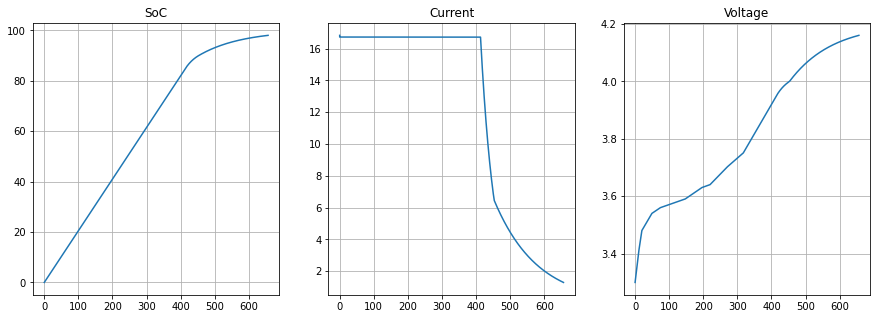

In [90]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(np.arange(0,t,1)/60,soc)
plt.grid('on')
plt.title('SoC')
plt.subplot(1, 3, 2)
plt.plot(np.arange(0,t,1)/60,np.multiply(curr,2))
plt.grid('on')
plt.title('Current')
plt.subplot(1, 3, 3)
plt.plot(np.arange(0,t,1)/60,v)#np.multiply(v,config_AUDI.no_series))
plt.grid('on')
plt.title('Voltage')